## How to use custom data and implement custom models and metrics

### Building a simple, first model
For demonstration purposes we will choose a simple fully connected model. It takes a timeseries of size input_size as input and outputs a new timeseries of size output_size. You can think of this input_size encoding steps and output_size decoding/prediction steps.

In [1]:
%load_ext lab_black

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")

In [3]:
import torch
from torch import nn


class FullyConnectedModule(nn.Module):
    def __init__(
        self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int
    ):
        super().__init__()

        # input layer
        module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        # hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        # output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.sequential = nn.Sequential(*module_list)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x of shape: batch_size x n_timesteps_in
        # output of shape batch_size x n_timesteps_out
        return self.sequential(x)


# test that network works as intended
network = FullyConnectedModule(
    input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2
)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

In [4]:
from typing import Dict

from pytorch_forecasting.models import BaseModel


class FullyConnectedModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        **kwargs
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

This is a very basic implementation that could be readily used for training. But before we add additional features, let's first have a look how we pass data to this model before we go about initializing our model.

### Passing data to a model

In [5]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) - 0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data

,value,group,time_idx
0,0.125697,0,0
1,0.403762,0,1
2,0.360060,0,2
3,-0.198817,0,3
4,-0.137271,0,4
5,0.093835,0,5
6,-0.432290,0,6
7,0.100604,0,7
8,0.273164,0,8
9,-0.128217,0,9


In [6]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

In [7]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(),
  'group': NaNLabelEncoder()},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

In [8]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 1.1905],
         [-0.7886],
         [-0.6738],
         [ 0.8220],
         [-0.5828]],

        [[ 1.3514],
         [ 0.3099],
         [-1.6969],
         [-0.9014],
         [ 1.5780]],

        [[-0.8128],
         [-0.5802],
         [ 0.2931],
         [-1.6950],
         [ 0.3187]],

        [[ 0.4135],
         [ 1.4642],
         [ 1.2991],
         [-0.8128],
         [-0.5802]]]), 'encoder_target': tensor([[ 0.3313, -0.1924, -0.1620,  0.2338, -0.1380],
        [ 0.3739,  0.0983, -0.4328, -0.2223,  0.4339],
        [-0.1988, -0.1373,  0.0938, -0.4323,  0.1006],
        [ 0.1257,  0.4038,  0.3601, -0.1988, -0.1373]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[-0.8725],
         [-1.2779]],

        [[-1.5186],
         [-0.2217]],

        [[ 0.9707],
         [-0.5460]],

        [[ 0.2931],
   

This explains why we had to first extract the correct input in our simple FullyConnectedModel above before passing it to our FullyConnectedModule. As a reminder:

In [9]:
def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # x is a batch generated based on the TimeSeriesDataset
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.network(network_input)

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

For such a simple architecture, we can ignore most of the inputs in x. You do not have to worry about moving tensors to specifc GPUs, PyTorch Lightning will take care of this for you.

Now, let's check if our model works. We initialize model always with their from_dataset() method with takes hyperparameters from the dataset, hyperparameters for the model and hyperparameters for the optimizer. Read more about it in the next section.

In [10]:
model = FullyConnectedModel.from_dataset(
    dataset, input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2
)
x, y = next(iter(dataloader))
model(x)

Output(prediction=tensor([[0.1097, 0.0525],
        [0.1010, 0.0457],
        [0.1001, 0.0422],
        [0.1156, 0.0545]], grad_fn=<AddBackward0>))

In [11]:
dataset.x_to_index(x)

,time_idx,group
0,7,1
1,5,0
2,6,2
3,5,2


### Coupling datasets and models

In [12]:
class FullyConnectedModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        **kwargs
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input).unsqueeze(-1)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs = {
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(
            kwargs
        )  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert (
            dataset.max_prediction_length == dataset.min_prediction_length
        ), "Decoder only supports a fixed length"
        assert (
            dataset.min_encoder_length == dataset.max_encoder_length
        ), "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

Now, let's initialize from our dataset:

In [13]:
model = FullyConnectedModel.from_dataset(dataset, hidden_size=10, n_hidden_layers=2)
model.summarize("full")  # print model summary
model.hparams

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:1726: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=-1` to replicate `mode=full` behavior.
  rank_zero_deprecation(

   | Name                 | Type                 | Params
---------------------------------------------------------------
0  | loss                 | SMAPE                | 0     
1  | logging_metrics      | ModuleList           | 0     
2  | network              | FullyConnectedModule | 302   
3  | network.sequential   | Sequential           | 302   
4  | network.sequential.0 | Linear               | 60    
5  | network.sequential.1 | ReLU                 | 0     
6  | network.sequential.2 | Linear               | 110   
7  | network.sequential.3 | ReLU                 | 0     
8  | network.sequential.4 | Linear               | 110   
9  | network.sequential.5 | ReLU                 | 0  

"hidden_size":                10
"input_size":                 5
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_hidden_layers":            2
"optimizer":                  ranger
"optimizer_params":           None
"output_size":                2
"output_transformer":         GroupNormalizer()
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"weight_decay":               0.0

### Defining additional hyperparameters

In [14]:
model.hparams

"hidden_size":                10
"input_size":                 5
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_hidden_layers":            2
"optimizer":                  ranger
"optimizer_params":           None
"output_size":                2
"output_transformer":         GroupNormalizer()
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"weight_decay":               0.0

In [15]:
print(BaseModel.__init__.__doc__)


        BaseModel for timeseries forecasting from which to inherit from

        Args:
            log_interval (Union[int, float], optional): Batches after which predictions are logged. If < 1.0, will log
                multiple entries per batch. Defaults to -1.
            log_val_interval (Union[int, float], optional): batches after which predictions for validation are
                logged. Defaults to None/log_interval.
            learning_rate (float, optional): Learning rate. Defaults to 1e-3.
            log_gradient_flow (bool): If to log gradient flow, this takes time and should be only done to diagnose
                training failures. Defaults to False.
            loss (Metric, optional): metric to optimize, can also be list of metrics. Defaults to SMAPE().
            logging_metrics (nn.ModuleList[MultiHorizonMetric]): list of metrics that are logged during training.
                Defaults to [].
            reduce_on_plateau_patience (int): patience after which 

## Classification

In [16]:
classification_test_data = pd.DataFrame(
    dict(
        target=np.random.choice(
            ["A", "B", "C"], size=30
        ),  # CHANGING values to predict to a categorical
        value=np.random.rand(
            30
        ),  # INPUT values - see next section on covariates how to use categorical inputs
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
classification_test_data

,target,value,group,time_idx
0,B,0.276194,0,0
1,C,0.186486,0,1
2,A,0.923356,0,2
3,B,0.894203,0,3
4,B,0.891172,0,4
5,A,0.876182,0,5
6,A,0.955440,0,6
7,A,0.484344,0,7
8,A,0.125132,0,8
9,C,0.081989,0,9


In [17]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# create the dataset from the pandas dataframe
classification_dataset = TimeSeriesDataSet(
    classification_test_data,
    group_ids=["group"],
    target="target",  # SWITCHING to categorical target
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
    target_normalizer=NaNLabelEncoder(),  # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(classification_dataset.to_dataloader(batch_size=4)))
y[0]  # target values are encoded categories

tensor([[2, 1],
        [0, 0],
        [0, 1],
        [1, 1]])

In [18]:
from pytorch_forecasting.metrics import CrossEntropy


class FullyConnectedClassificationModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        n_classes: int,
        loss=CrossEntropy(),
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size * self.hparams.n_classes,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_cont"].size(0)
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)
        # RESHAPE output to batch_size x n_decoder_timesteps x n_classes
        prediction = prediction.unsqueeze(-1).view(
            batch_size, -1, self.hparams.n_classes
        )

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a named tuple that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        assert isinstance(
            dataset.target_normalizer, NaNLabelEncoder
        ), "target normalizer has to encode categories"
        new_kwargs = {
            "n_classes": len(
                dataset.target_normalizer.classes_
            ),  # ADD number of classes as encoded by the target normalizer
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(
            kwargs
        )  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert (
            dataset.max_prediction_length == dataset.min_prediction_length
        ), "Decoder only supports a fixed length"
        assert (
            dataset.min_encoder_length == dataset.max_encoder_length
        ), "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
        ), "Only covariate should be in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)


model = FullyConnectedClassificationModel.from_dataset(
    classification_dataset, hidden_size=10, n_hidden_layers=2
)
model.summarize("full")
model.hparams

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:1726: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=-1` to replicate `mode=full` behavior.
  rank_zero_deprecation(

   | Name                 | Type                 | Params
---------------------------------------------------------------
0  | loss                 | SMAPE                | 0     
1  | logging_metrics      | ModuleList           | 0     
2  | network              | FullyConnectedModule | 346   
3  | network.sequential   | Sequential           | 346   
4  | network.sequential.0 | Linear               | 60    
5  | network.sequential.1 | ReLU                 | 0     
6  | network.sequential.2 | Linear               | 110   
7  | network.sequential.3 | ReLU                 | 0     
8  | network.sequential.4 | Linear               | 110   
9  | network.sequential.5 | ReLU                 | 0  

"hidden_size":                10
"input_size":                 5
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_classes":                  3
"n_hidden_layers":            2
"optimizer":                  ranger
"optimizer_params":           None
"output_size":                2
"output_transformer":         NaNLabelEncoder()
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"weight_decay":               0.0

In [19]:
# passing x through model
model(x)["prediction"].shape

torch.Size([4, 2, 3])

## Predicting multiple targets at the same time
Training a model to predict multiple targets simulateneously is not difficult to implement. We can even employ mixed targets, i.e. a mix of categorical and continous targets. The first step is to use define a dataframe with multiple targets:

In [20]:
multi_target_test_data = pd.DataFrame(
    dict(
        target1=np.random.rand(30),
        target2=np.random.rand(30),
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
multi_target_test_data

,target1,target2,group,time_idx
0,0.343665,0.516140,0,0
1,0.608444,0.571139,0,1
2,0.159687,0.851720,0,2
3,0.885167,0.954097,0,3
4,0.259125,0.474496,0,4
5,0.669304,0.675852,0,5
6,0.766701,0.020324,0,6
7,0.351634,0.288928,0,7
8,0.034312,0.845248,0,8
9,0.504706,0.325650,0,9


In [21]:
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    MultiNormalizer,
    TorchNormalizer,
)

# create the dataset from the pandas dataframe
multi_target_dataset = TimeSeriesDataSet(
    multi_target_test_data,
    group_ids=["group"],
    target=["target1", "target2"],  # USING two targets
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["target1", "target2"],
    target_normalizer=MultiNormalizer(
        [EncoderNormalizer(), TorchNormalizer()]
    ),  # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(multi_target_dataset.to_dataloader(batch_size=4)))
y[0]  # target values are a list of targets

[tensor([[0.3555, 0.7274],
         [0.3516, 0.0343],
         [0.9740, 0.7852],
         [0.7682, 0.8540]]),
 tensor([[0.5324, 0.0569],
         [0.2889, 0.8452],
         [0.5128, 0.2703],
         [0.9592, 0.9163]])]

In [22]:
from typing import List, Union

from pytorch_forecasting.metrics import MAE, SMAPE, MultiLoss
from pytorch_forecasting.utils import to_list


class FullyConnectedMultiTargetModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        target_sizes: Union[int, List[int]] = [],
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size
            * len(to_list(self.hparams.target_sizes)),
            output_size=self.hparams.output_size
            * sum(to_list(self.hparams.target_sizes)),
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_cont"].size(0)
        network_input = x["encoder_cont"].view(batch_size, -1)
        prediction = self.network(network_input)
        # RESHAPE output to batch_size x n_decoder_timesteps x sum_of_target_sizes
        prediction = prediction.unsqueeze(-1).view(
            batch_size, self.hparams.output_size, sum(self.hparams.target_sizes)
        )
        # RESHAPE into list of batch_size x n_decoder_timesteps x target_sizes[i] where i=1..len(target_sizes)
        stops = np.cumsum(self.hparams.target_sizes)
        starts = stops - self.hparams.target_sizes
        prediction = [prediction[..., start:stop] for start, stop in zip(starts, stops)]
        if isinstance(self.hparams.target_sizes, int):  # only one target
            prediction = prediction[0]

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a named tuple that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        # By default only handle targets of size one here, categorical targets would be of larger size
        new_kwargs = {
            "target_sizes": [1] * len(to_list(dataset.target)),
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(
            kwargs
        )  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert (
            dataset.max_prediction_length == dataset.min_prediction_length
        ), "Decoder only supports a fixed length"
        assert (
            dataset.min_encoder_length == dataset.max_encoder_length
        ), "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals)
            == len(dataset.target_names)  # Expect as as many unknown reals as targets
        ), "Only covariate should be in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)


model = FullyConnectedMultiTargetModel.from_dataset(
    multi_target_dataset,
    hidden_size=10,
    n_hidden_layers=2,
    loss=MultiLoss(metrics=[MAE(), SMAPE()], weights=[2.0, 1.0]),
)
model.summarize("full")
model.hparams

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:1726: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=-1` to replicate `mode=full` behavior.
  rank_zero_deprecation(

   | Name                 | Type                 | Params
---------------------------------------------------------------
0  | loss                 | MultiLoss            | 0     
1  | logging_metrics      | ModuleList           | 0     
2  | network              | FullyConnectedModule | 374   
3  | network.sequential   | Sequential           | 374   
4  | network.sequential.0 | Linear               | 110   
5  | network.sequential.1 | ReLU                 | 0     
6  | network.sequential.2 | Linear               | 110   
7  | network.sequential.3 | ReLU                 | 0     
8  | network.sequential.4 | Linear               | 110   
9  | network.sequential.5 | ReLU                 | 0  

"hidden_size":                10
"input_size":                 5
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_hidden_layers":            2
"optimizer":                  ranger
"optimizer_params":           None
"output_size":                2
"output_transformer":         MultiNormalizer(normalizers=[EncoderNormalizer(), TorchNormalizer()])
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"target_sizes":               [1, 1]
"weight_decay":               0.0

In [23]:
out = model(x)
out

Output(prediction=[tensor([[[0.7428],
         [0.6436]],

        [[0.6099],
         [0.5157]],

        [[0.5959],
         [0.4909]],

        [[0.4156],
         [0.3782]]], grad_fn=<AddBackward0>), tensor([[[0.4682],
         [0.5384]],

        [[0.4769],
         [0.5505]],

        [[0.4573],
         [0.5471]],

        [[0.4699],
         [0.5610]]], dtype=torch.float64, grad_fn=<AddBackward0>)])

In [24]:
model.loss(out["prediction"], y)

tensor(1.2549, dtype=torch.float64, grad_fn=<SumBackward1>)

## Using covariates

In [25]:
from pytorch_forecasting.models.base_model import BaseModelWithCovariates

print(BaseModelWithCovariates.__doc__)


    Model with additional methods using covariates.

    Assumes the following hyperparameters:

    Args:
        static_categoricals (List[str]): names of static categorical variables
        static_reals (List[str]): names of static continuous variables
        time_varying_categoricals_encoder (List[str]): names of categorical variables for encoder
        time_varying_categoricals_decoder (List[str]): names of categorical variables for decoder
        time_varying_reals_encoder (List[str]): names of continuous variables for encoder
        time_varying_reals_decoder (List[str]): names of continuous variables for decoder
        x_reals (List[str]): order of continuous variables in tensor passed to forward function
        x_categoricals (List[str]): order of categorical variables in tensor passed to forward function
        embedding_sizes (Dict[str, Tuple[int, int]]): dictionary mapping categorical variables to tuple of integers
            where the first integer denotes the nu

In [26]:
from typing import Dict, List, Tuple

from pytorch_forecasting.models.nn import MultiEmbedding


class FullyConnectedModelWithCovariates(BaseModelWithCovariates):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        x_reals: List[str],
        x_categoricals: List[str],
        embedding_sizes: Dict[str, Tuple[int, int]],
        embedding_labels: Dict[str, List[str]],
        static_categoricals: List[str],
        static_reals: List[str],
        time_varying_categoricals_encoder: List[str],
        time_varying_categoricals_decoder: List[str],
        time_varying_reals_encoder: List[str],
        time_varying_reals_decoder: List[str],
        embedding_paddings: List[str],
        categorical_groups: Dict[str, List[str]],
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # create embedder - can be fed with x["encoder_cat"] or x["decoder_cat"] and will return
        # dictionary of category names mapped to embeddings
        self.input_embeddings = MultiEmbedding(
            embedding_sizes=self.hparams.embedding_sizes,
            categorical_groups=self.hparams.categorical_groups,
            embedding_paddings=self.hparams.embedding_paddings,
            x_categoricals=self.hparams.x_categoricals,
            max_embedding_size=self.hparams.hidden_size,
        )

        # calculate the size of all concatenated embeddings + continous variables
        n_features = sum(
            embedding_size
            for classes_size, embedding_size in self.hparams.embedding_sizes.values()
        ) + len(self.reals)

        # create network that will be fed with continious variables and embeddings
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size * n_features,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_lengths"].size(0)
        embeddings = self.input_embeddings(
            x["encoder_cat"]
        )  # returns dictionary with embedding tensors
        network_input = torch.cat(
            [x["encoder_cont"]]
            + [
                emb
                for name, emb in embeddings.items()
                if name in self.encoder_variables or name in self.static_variables
            ],
            dim=-1,
        )
        prediction = self.network(network_input.view(batch_size, -1))

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs = {
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(
            kwargs
        )  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert (
            dataset.max_prediction_length == dataset.min_prediction_length
        ), "Decoder only supports a fixed length"
        assert (
            dataset.min_encoder_length == dataset.max_encoder_length
        ), "Encoder only supports a fixed length"

        return super().from_dataset(dataset, **new_kwargs)

In [27]:
import numpy as np
import pandas as pd

from pytorch_forecasting import TimeSeriesDataSet

test_data_with_covariates = pd.DataFrame(
    dict(
        # as before
        value=np.random.rand(30),
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
        # now adding covariates
        categorical_covariate=np.random.choice(["a", "b"], size=30),
        real_covariate=np.random.rand(30),
    )
).astype(
    dict(group=str)
)  # categorical covariates have to be of string type
test_data_with_covariates

,value,group,time_idx,categorical_covariate,real_covariate
0,0.774005,0,0,a,0.333642
1,0.720550,0,1,a,0.712037
2,0.761146,0,2,a,0.444420
3,0.342583,0,3,b,0.819633
4,0.946751,0,4,a,0.141854
5,0.159947,0,5,b,0.533876
6,0.887627,0,6,b,0.706678
7,0.743960,0,7,b,0.687738
8,0.605190,0,8,a,0.751191
9,0.523593,0,9,a,0.955520


In [28]:
# create the dataset from the pandas dataframe
dataset_with_covariates = TimeSeriesDataSet(
    test_data_with_covariates,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["real_covariate"],
    time_varying_known_categoricals=["categorical_covariate"],
    static_categoricals=["group"],
)

model = FullyConnectedModelWithCovariates.from_dataset(
    dataset_with_covariates, hidden_size=10, n_hidden_layers=2
)
model.summarize("full")  # print model summary
model.hparams

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:1726: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=-1` to replicate `mode=full` behavior.
  rank_zero_deprecation(

   | Name                                              | Type                 | Params
--------------------------------------------------------------------------------------------
0  | loss                                              | SMAPE                | 0     
1  | logging_metrics                                   | ModuleList           | 0     
2  | input_embeddings                                  | MultiEmbedding       | 11    
3  | input_embeddings.embeddings                       | ModuleDict           | 11    
4  | input_embeddings.embeddings.group                 | Embedding            | 9     
5  | input_embeddings.embeddings.categorical_covariate | Embedding            | 2  

"categorical_groups":                {}
"embedding_labels":                  {'group': {'0': 0, '1': 1, '2': 2}, 'categorical_covariate': {'a': 0, 'b': 1}}
"embedding_paddings":                []
"embedding_sizes":                   {'group': [3, 3], 'categorical_covariate': [2, 1]}
"hidden_size":                       10
"input_size":                        5
"learning_rate":                     0.001
"log_gradient_flow":                 False
"log_interval":                      -1
"log_val_interval":                  -1
"logging_metrics":                   ModuleList()
"monotone_constaints":               {}
"n_hidden_layers":                   2
"optimizer":                         ranger
"optimizer_params":                  None
"output_size":                       2
"output_transformer":                GroupNormalizer(transformation='relu')
"reduce_on_plateau_min_lr":          1e-05
"reduce_on_plateau_patience":        1000
"static_categoricals":               ['group']
"static_r

In [29]:
x, y = next(iter(dataset_with_covariates.to_dataloader(batch_size=4)))  # generate batch
model(x)  # pass batch through model

Output(prediction=tensor([[0.5737, 0.6066],
        [0.5831, 0.6082],
        [0.5680, 0.5922],
        [0.5961, 0.6188]], grad_fn=<ClampBackward1>))

## Implementing an autoregressive / recurrent model

In [30]:
from torch.nn.utils import rnn

from pytorch_forecasting.models.base_model import AutoRegressiveBaseModel
from pytorch_forecasting.models.nn import LSTM


class LSTMModel(AutoRegressiveBaseModel):
    def __init__(
        self,
        target: str,
        target_lags: Dict[str, Dict[str, int]],
        n_layers: int,
        hidden_size: int,
        dropout: float = 0.1,
        **kwargs,
    ):
        # arguments target and target_lags are required for autoregressive models
        # even though target_lags cannot be used without covariates
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # use version of LSTM that can handle zero-length sequences
        self.lstm = LSTM(
            hidden_size=self.hparams.hidden_size,
            input_size=1,
            num_layers=self.hparams.n_layers,
            dropout=self.hparams.dropout,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hparams.hidden_size, 1)

    def encode(self, x: Dict[str, torch.Tensor]):
        # we need at least one encoding step as because the target needs to be lagged by one time step
        # because we use the custom LSTM, we do not have to require encoder lengths of > 1
        # but can handle lengths of >= 1
        assert x["encoder_lengths"].min() >= 1
        input_vector = x["encoder_cont"].clone()
        # lag target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        input_vector = input_vector[
            :, 1:
        ]  # first time step cannot be used because of lagging

        # determine effective encoder_length length
        effective_encoder_lengths = x["encoder_lengths"] - 1
        # run through LSTM network
        _, hidden_state = self.lstm(
            input_vector,
            lengths=effective_encoder_lengths,
            enforce_sorted=False,  # passing the lengths directly
        )  # second ouput is not needed (hidden state)
        return hidden_state

    def decode(self, x: Dict[str, torch.Tensor], hidden_state):
        # again lag target by one
        input_vector = x["decoder_cont"].clone()
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        # but this time fill in missing target from encoder_cont at the first time step instead of throwing it away
        last_encoder_target = x["encoder_cont"][
            torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
            x["encoder_lengths"] - 1,
            self.target_positions.unsqueeze(-1),
        ].T
        input_vector[:, 0, self.target_positions] = last_encoder_target

        if self.training:  # training mode
            lstm_output, _ = self.lstm(
                input_vector,
                hidden_state,
                lengths=x["decoder_lengths"],
                enforce_sorted=False,
            )

            # transform into right shape
            prediction = self.output_layer(lstm_output)
            prediction = self.transform_output(
                prediction, target_scale=x["target_scale"]
            )

            # predictions are not yet rescaled
            return prediction

        else:  # prediction mode
            target_pos = self.target_positions

            def decode_one(idx, lagged_targets, hidden_state):
                x = input_vector[:, [idx]]
                # overwrite at target positions
                x[:, 0, target_pos] = lagged_targets[
                    -1
                ]  # take most recent target (i.e. lag=1)
                lstm_output, hidden_state = self.lstm(x, hidden_state)
                # transform into right shape
                prediction = self.output_layer(lstm_output)[:, 0]  # take first timestep
                return prediction, hidden_state

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],
                first_hidden_state=hidden_state,
                target_scale=x["target_scale"],
                n_decoder_steps=input_vector.size(1),
            )

            # predictions are already rescaled
            return output

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        hidden_state = self.encode(x)  # encode to hidden state
        output = self.decode(x, hidden_state)  # decode leveraging hidden state

        return self.to_network_output(prediction=output)


model = LSTMModel.from_dataset(dataset, n_layers=2, hidden_size=10)
model.summarize("full")
model.hparams


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 1.4 K 
3 | output_layer    | Linear     | 11    
-----------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


"dropout":                    0.1
"hidden_size":                10
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_layers":                   2
"optimizer":                  ranger
"optimizer_params":           None
"output_transformer":         GroupNormalizer()
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"target":                     value
"target_lags":                {}
"weight_decay":               0.0

In [31]:
x, y = next(iter(dataloader))

print(
    "prediction shape in training:", model(x)["prediction"].size()
)  # batch_size x decoder time steps x 1 (1 for one target dimension)
model.eval()  # set model into eval mode to use autoregressive prediction
print(
    "prediction shape in inference:", model(x)["prediction"].size()
)  # should be the same as in training

prediction shape in training: torch.Size([4, 2, 1])
prediction shape in inference: torch.Size([4, 2, 1])


## Using and defining a custom/non-trivial metric
To use a different metric, simply pass it to the model when initializing it (preferably via the from_dataset() method). For example, to use mean absolute error with our FullyConnectedModel from the beginning of this tutorial, type

In [32]:
from pytorch_forecasting.metrics import MAE

model = FullyConnectedModel.from_dataset(
    dataset, hidden_size=10, n_hidden_layers=2, loss=MAE()
)
model.hparams

"hidden_size":                10
"input_size":                 5
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_hidden_layers":            2
"optimizer":                  ranger
"optimizer_params":           None
"output_size":                2
"output_transformer":         GroupNormalizer()
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"weight_decay":               0.0

In [33]:
import torch
from torch import nn


class FullyConnectedMultiOutputModule(nn.Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        n_outputs: int,
    ):
        super().__init__()

        # input layer
        module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        # hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        # output layer
        self.n_outputs = n_outputs
        module_list.append(
            nn.Linear(hidden_size, output_size * n_outputs)
        )  # <<<<<<<< modified: replaced output_size with output_size * n_outputs

        self.sequential = nn.Sequential(*module_list)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x of shape: batch_size x n_timesteps_in
        # output of shape batch_size x n_timesteps_out
        return self.sequential(x).reshape(
            x.size(0), -1, self.n_outputs
        )  # <<<<<<<< modified: added reshape


# test that network works as intended
network = FullyConnectedMultiOutputModule(
    input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2, n_outputs=7
)
network(
    torch.rand(20, 5)
).shape  # <<<<<<<<<< instead of shape (20, 2), returning additional dimension for quantiles

torch.Size([20, 2, 7])

### Implement a new metric

In [34]:
from pytorch_forecasting.metrics import MultiHorizonMetric


class MAE(MultiHorizonMetric):
    def loss(self, y_pred, target):
        loss = (self.to_prediction(y_pred) - target).abs()
        return loss

### Model ouptut cannot be readily converted to prediction

In [35]:
from copy import copy

from pytorch_forecasting.metrics import NormalDistributionLoss


class FullyConnectedForDistributionLossModel(
    BaseModel
):  # we inherit the `from_dataset` method
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        **kwargs
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedMultiOutputModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
            n_outputs=2,  # <<<<<<<< we predict two outputs for mean and scale of the normal distribution
        )
        self.loss = NormalDistributionLoss()

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs = {
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(
            kwargs
        )  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert (
            dataset.max_prediction_length == dataset.min_prediction_length
        ), "Decoder only supports a fixed length"
        assert (
            dataset.min_encoder_length == dataset.max_encoder_length
        ), "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

    def forward(
        self, x: Dict[str, torch.Tensor], n_samples: int = None
    ) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(
            network_input
        )  # shape batch_size x n_decoder_steps x 2
        # we need to scale the parameters to real space
        prediction = self.transform_output(
            prediction=prediction,
            target_scale=x["target_scale"],
        )
        if n_samples is not None:
            # sample from distribution
            prediction = self.loss.sample(prediction, n_samples)
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)


model = FullyConnectedForDistributionLossModel.from_dataset(
    dataset, hidden_size=10, n_hidden_layers=2
)
model.summarize("full")
model.hparams


   | Name                 | Type                            | Params
--------------------------------------------------------------------------
0  | loss                 | NormalDistributionLoss          | 0     
1  | logging_metrics      | ModuleList                      | 0     
2  | network              | FullyConnectedMultiOutputModule | 324   
3  | network.sequential   | Sequential                      | 324   
4  | network.sequential.0 | Linear                          | 60    
5  | network.sequential.1 | ReLU                            | 0     
6  | network.sequential.2 | Linear                          | 110   
7  | network.sequential.3 | ReLU                            | 0     
8  | network.sequential.4 | Linear                          | 110   
9  | network.sequential.5 | ReLU                            | 0     
10 | network.sequential.6 | Linear                          | 44    
--------------------------------------------------------------------------
324       Trainable p

"hidden_size":                10
"input_size":                 5
"learning_rate":              0.001
"log_gradient_flow":          False
"log_interval":               -1
"log_val_interval":           -1
"logging_metrics":            ModuleList()
"monotone_constaints":        {}
"n_hidden_layers":            2
"optimizer":                  ranger
"optimizer_params":           None
"output_size":                2
"output_transformer":         GroupNormalizer()
"reduce_on_plateau_min_lr":   1e-05
"reduce_on_plateau_patience": 1000
"weight_decay":               0.0

In [36]:
x["decoder_lengths"]

tensor([2, 2, 2, 2])

In [37]:
x, y = next(iter(dataloader))

print("parameter predition shape: ", model(x)["prediction"].size())
model.eval()  # set model into eval mode for sampling
print("sample prediction shape: ", model(x, n_samples=200)["prediction"].size())

parameter predition shape:  torch.Size([4, 2, 2])
sample prediction shape:  torch.Size([4, 2, 200])


In [38]:
model.predict(dataloader, mode="quantiles", mode_kwargs=dict(n_samples=100)).shape

torch.Size([12, 2, 7])

In [39]:
model.loss.quantiles

[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

In [40]:
NormalDistributionLoss(quantiles=[0.2, 0.8]).quantiles

[0.2, 0.8]

## Adding custom plotting and interpretation
### Log often whenever an example prediction vs actuals plot is created

In [41]:
import matplotlib.pyplot as plt


def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = super().plot_prediction(
        x,
        out,
        idx=idx,
        add_loss_to_title=add_loss_to_title,
        show_future_observed=show_future_observed,
        ax=ax,
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

### Log at the end of an epoch

In [42]:
from pytorch_forecasting.utils import detach


def create_log(self, x, y, out, batch_idx, **kwargs):
    # log standard
    log = super().create_log(x, y, out, batch_idx, **kwargs)
    # calculate interpretations etc for latter logging
    if self.log_interval > 0:
        interpretation = self.interpret_output(
            detach(out),
            reduction="sum",
            attention_prediction_horizon=0,  # attention only for first prediction horizon
        )
        log["interpretation"] = interpretation
    return log


def epoch_end(self, outputs):
    """
    Run at epoch end for training or validation
    """
    if self.log_interval > 0:
        self.log_interpretation(outputs)

### Log at the end of training

In [43]:
def on_fit_end(self):
    """
    run at the end of training
    """
    if self.log_interval > 0:
        for name, emb in self.input_embeddings.items():
            labels = self.hparams.embedding_labels[name]
            self.logger.experiment.add_embedding(
                emb.weight.data.cpu(),
                metadata=labels,
                tag=name,
                global_step=self.global_step,
            )

## Minimal testing of models
Testing models is essential to quickly detect problems and iterate quickly. Some issues can be only identified after lengthy training but many problems show up after one or two batches. PyTorch Lightning, on which PyTorch Forecasting is built, makes it easy to set up such tests.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type                            | Params
--------------------------------------------------------------------
0 | loss            | NormalDistributionLoss          | 0     
1 | logging_metrics | ModuleList                      | 0     
2 | network         | FullyConnectedMultiOutputModule | 324   
--------------------------------------------------------------------
324       Trainable params
0         Non-trainable params
324       Total params
0.001     Total estim

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=1.42, v_num=, train_loss_step=1.420]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  2.38it/s, loss=1.42, v_num=, train_loss_step=1.420, val_loss=0.857]


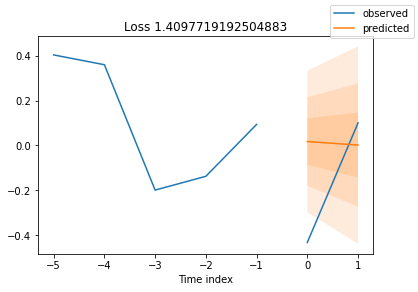

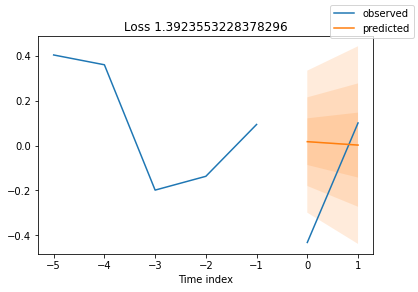

In [44]:
from pytorch_lightning import Trainer

model = FullyConnectedForDistributionLossModel.from_dataset(
    dataset, hidden_size=10, n_hidden_layers=2, log_interval=1
)
trainer = Trainer(fast_dev_run=True)
trainer.fit(model, train_dataloader=dataloader, val_dataloaders=dataloader)